# Try changing the labels to [0 0.25 0.5 1]
## I don't think is actually necessary to make a prob of this one. The results are not that promising and don't work for everyone.

This run has higher dropout, larger size lstm.

This run has validation accuracy around 70%+

From results shown, high dropout does contribute to regularization. Compared to the first run, validation accuracy doesn't improve, however the training history is less oscillatory.

In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Activation, Flatten
from keras.utils import to_categorical
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing

from Code.data_loaders import load_data_labels_based_on_dataset
from share import datasets_basic_infos
from Code.data_utils import train_test_val_split

In [21]:

subject_id = 1  # Only two things I should be able to change
dataset_name = 'torres'  # Only two things I should be able to change

# Folders and paths
dataset_foldername = dataset_name + '_dataset'
data_path = "/Users/almacuevas/work_projects/voting_system_platform/Datasets/" + dataset_foldername
dataset_info = datasets_basic_infos[dataset_name]

data, label = load_data_labels_based_on_dataset(dataset_name, subject_id, data_path, array_format=True)

In [22]:
num_classes = 4

# substract data from list
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(dataX = data, dataY= label, valid_flag=True)

# get data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape
N_test, T_test, C_test = X_test.shape

y_test

array([0, 2, 0, 0, 3, 2, 3, 0, 2, 0, 0, 3, 2, 2])

In [23]:
# add dummy zeros for y classification, convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [24]:
# construct X_total and y_total based on sub-sampling of X_train and y_train

# take sub-sampling on the time sequence to reduce dimension for RNN
sampling = 1

X_train = X_train.reshape(N_train,int(T_train/sampling), sampling, C_train)[:,:,0,:]
X_val = X_val.reshape(N_val,int(T_val/sampling), sampling, C_val)[:,:,0,:]
X_test = X_test.reshape(N_test,int(T_test/sampling), sampling, C_test)[:,:,0,:]

# get new data dimension
N_train, T_train, C_train = X_train.shape
N_val, T_val, C_val = X_val.shape
N_test, T_test, C_test = X_test.shape

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (99, 14, 421)
y_train:  (99, 4)
X_val:  (19, 14, 421)
y_val:  (19, 4)
X_test:  (14, 14, 421)
y_test:  (14, 4)


In [25]:
# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
timesteps = T_train
batch_size = y_train.shape[0]
num_epoch = y_train.shape[0]

# make a sequential model
model = Sequential()

# add 1-layer cnn
model.add(Conv1D(40, kernel_size=20, strides=4,
          input_shape=(timesteps, data_dim)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
#model.add(MaxPooling1D(pool_size=4, strides=4))


# add 2-layer lstm
model.add(LSTM(30, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(LSTM(20, return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# set loss function and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_3. Consider increasing the input size. Received input shape [None, 14, 421] which would produce output shape with a zero or negative value in a dimension.

In [18]:
# train the data with validation
history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epoch, 
                    shuffle=False,
                    validation_data=(X_val, y_val))

Epoch 1/90
1/1 [==============================] - 1s 1s/step - loss: 1.7303 - accuracy: 0.3000 - val_loss: 1.3966 - val_accuracy: 0.2222
Epoch 2/90
1/1 [==============================] - 0s 32ms/step - loss: 1.7796 - accuracy: 0.2556 - val_loss: 1.3841 - val_accuracy: 0.2778
Epoch 3/90
1/1 [==============================] - 0s 19ms/step - loss: 1.7335 - accuracy: 0.2889 - val_loss: 1.3856 - val_accuracy: 0.2778
Epoch 4/90
1/1 [==============================] - 0s 26ms/step - loss: 1.7265 - accuracy: 0.2556 - val_loss: 1.3856 - val_accuracy: 0.2778
Epoch 5/90
1/1 [==============================] - 0s 20ms/step - loss: 1.7496 - accuracy: 0.3000 - val_loss: 1.3861 - val_accuracy: 0.2778
Epoch 6/90
1/1 [==============================] - 0s 23ms/step - loss: 1.5819 - accuracy: 0.3000 - val_loss: 1.3864 - val_accuracy: 0.2778
Epoch 7/90
1/1 [==============================] - 0s 22ms/step - loss: 1.8681 - accuracy: 0.2111 - val_loss: 1.3867 - val_accuracy: 0.2778
Epoch 8/90
1/1 [=============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


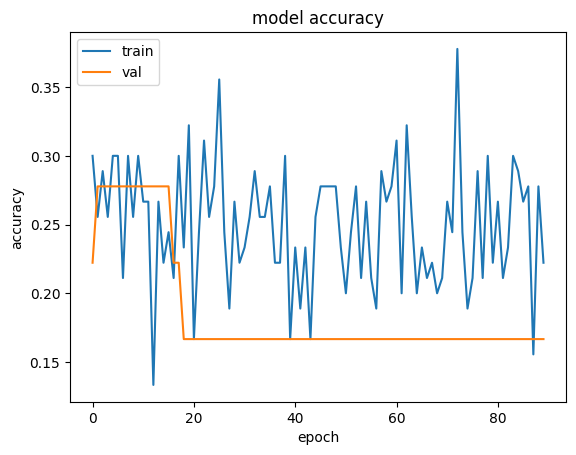

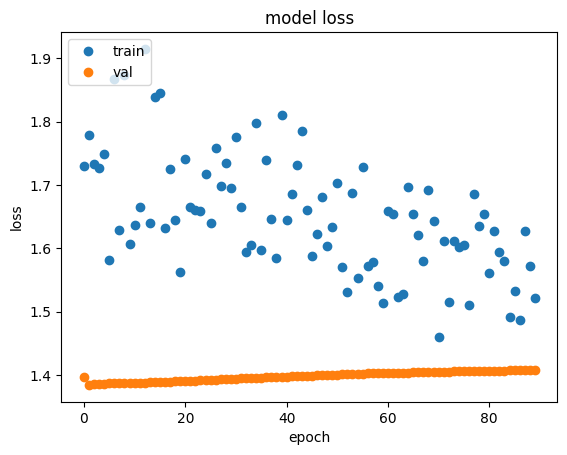

In [19]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# test set
results = model.evaluate(X_test,y_test,batch_size=N_test)
print("test loss, test acc:", results)

1/1 [==============================] - 0s 30ms/step - loss: 1.4346 - accuracy: 0.1667
test loss, test acc: [1.4346370697021484, 0.1666666716337204]
